## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


### Load packages

In [11]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup

from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import mostcommon_crs

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37755 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35271 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/37755/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


## Setup

In [3]:
dc = datacube.Datacube(app='Intertidal_elevation')

In [8]:
aoi = 'Wollogorang'
# aoi = 'McCarthur River'
# aoi = 'Greenbank'
# aoi = 'Seven Emu'

time_range = ('2017', '2021')
resolution = 10

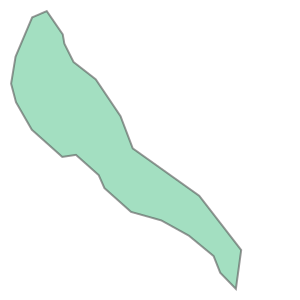

In [9]:
# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

## Load data

In [14]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range,
    'gqa_iterative_mean_xy': [0, 1]}
    
load_params = {
    'group_by': 'solar_day',
    'resampling': {'*': 'average', 'fmask': 'nearest'},
    'dask_chunks': {'time': 1, 'x': 2048, 'y': 2048}
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ga_s2am_ard_3', 
                            query=query_params)